In [6]:
import ssm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

/home/huang/anaconda3/envs/NMA_project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# get all 39 sessions
alldat = np.array([])
for j in range(3):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))
                              
alldat.shape

(39,)

In [8]:
dat = alldat[11]   # a dict
print('keys:', len(dat.keys()), dat.keys())

print('')
print('mouse_name:', dat['mouse_name'])
print('date_exp:', dat['date_exp'])
print('brain_area:', dat['brain_area'].shape, np.unique(dat['brain_area']))

print('')
print('bin_size:', dat['bin_size'])
print('stim_onset:', dat['stim_onset'])
print('spks(neurons*trials*time_bins):', dat['spks'].shape, np.unique(dat['spks']))

print('')
print('gocue:', dat['gocue'].shape)
print('contrast_right:', dat['contrast_right'].shape, np.unique(dat['contrast_right']))
print('contrast_left:', dat['contrast_left'].shape, np.unique(dat['contrast_left']))
print('feedback_time:', dat['feedback_time'].shape)
print('feedback_type:', dat['feedback_type'].shape, np.unique(dat['feedback_type']))
print('response_time:', dat['response_time'].shape)
print('response:', dat['response'].shape, np.unique(dat['response']))

print('')
print('active_trials:', dat['active_trials'].shape)
print('reaction_time:', dat['reaction_time'].shape)

print('')
print('pupil:', dat['pupil'].shape)
print('wheel:', dat['wheel'].shape)

keys: 31 dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])

mouse_name: Lederberg
date_exp: 2017-12-05
brain_area: (698,) ['ACA' 'CA1' 'DG' 'LGd' 'LH' 'MD' 'MOs' 'PL' 'SUB' 'VISam' 'VISp' 'root']

bin_size: 0.01
stim_onset: 0.5
spks(neurons*trials*time_bins): (698, 340, 250) [0 1 2 3 4 5 6]

gocue: (340, 1)
contrast_right: (340,) [0.   0.25 0.5  1.  ]
contrast_left: (340,) [0.   0.25 0.5  1.  ]
feedback_time: (340, 1)
feedback_type: (340,) [-1.  1.]
response_time: (340, 1)
response: (340,) [-1.  0.  1.]

active_trials: (450,)
reaction_time: (340, 2)

pupil: (3, 340, 250)
wheel: (1

In [9]:
brain_areas = dat['brain_area']
bin_size = dat['bin_size']
stim_onset = dat['stim_onset']
gocue = dat['gocue'] + stim_onset
feedback_time = dat['feedback_time'] + stim_onset
response_time = dat['response_time'] + stim_onset
neural_activity = dat['spks']

# stim_onset = int(stim_onset/bin_size)
# response_time = response_time/bin_size

In [10]:
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

nareas = 4  # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area'])  # number of neurons
barea = nareas * np.ones(NN, )  # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign a number to each region

np.unique(barea, return_counts=True)

(array([0., 1., 2., 3., 4.]), array([145, 155, 220,  78, 100]))

In [11]:
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
vis_stim = vis_left - vis_right # right - nogo - left
# trials types by response
resp_left_id = response > 0
resp_no_id = response == 0
resp_right_id = response < 0
# trials types by visual stimuli
vis_left_id = vis_stim > 0
vis_no_id = vis_stim == 0
vis_right_id = vis_stim < 0
# trials types by result
correct_id_left = np.logical_and(vis_left > 0, response > 0)
orrect_id_no = np.logical_and(vis_left == 0, response == 0)
orrect_id_right = np.logical_and(vis_left < 0, response < 0)
correct_id = np.logical_or(correct_id_left, orrect_id_no, orrect_id_right)
incorrect_id = np.logical_not(correct_id)

In [12]:
# plot_hist_transition
def plot_hist_transition(states_seq,trial_types,regions):
#histogram showing the distribution of how long the system can stay in a certain state during the whole session

    state_time = [[] for i in range(3)]

    dur = 0

    for i in range(len(states_seq)-1):
        if states_seq[i+1] == states_seq[i]:
            dur += 1
        else:
            state_time[int(states_seq[i])].append(dur+1)
            dur = 0

    state_time = np.array(state_time,dtype=object)

    f, ax = plt.subplots(figsize=(24, 10))
    colors = ['lightcoral','palegreen','cornflowerblue']

    for i in range(3):
        n, bins, patches = ax.hist(state_time[i],
                                   color=colors[i], 
                                   bins=50,range={0,300}, 
                                   histtype="stepfilled", 
                                   alpha = 0.5,
                                   label = 'state'+str(i+1))
        n_ = np.hstack((np.zeros(1),n))
        plt.step(bins, n_,color=colors[i])

    ax.set_xlabel("Duration")
    ax.set_ylabel("section #")
    ax.set_title(f'{trial_types}, area {regions}')
    plt.legend()

In [13]:
# plot_hist_duration
def plot_hist_duration(states_seq, trials, time_bins,num_states,trial_types,regions):
# histogram showing the distribution of total time of the system being in a state per trial
    
    states_seq_rs = states_seq.reshape(trials,time_bins)
    dur_per_trial = np.zeros((num_states,states_seq_rs.shape[0]))

    for i, trial in enumerate(states_seq_rs):
        states, counts = np.unique(trial, return_counts=True)
        for k,j in enumerate(states):
            dur_per_trial[j,i] = counts[k]

    hist_dur = [[] for i in range(3)]
    for i in range(3):
        dur_state = dur_per_trial[i]
        hist_dur[i] = dur_state#[dur_state!=0]

    f, ax = plt.subplots(figsize=(24, 10))
    colors = ['lightcoral','palegreen','cornflowerblue']

    for i in range(3):
        n, bins, patches = ax.hist(hist_dur[i],
                                   color=colors[i], 
                                   bins=50,range={0,np.max(dur_per_trial)}, 
                                   histtype="stepfilled", 
                                   alpha = 0.5,
                                   label = 'state'+str(i+1))
        n_ = np.hstack((np.zeros(1),n))
        plt.step(bins, n_,color=colors[i])

    ax.set_xlabel("Total Duration")
    ax.set_ylabel("Trial #")
    ax.set_title(f'{trial_types}, area {regions}')
    plt.legend()

LP: -481733.7: 100%|██████████████████████████| 300/300 [01:38<00:00,  3.03it/s]


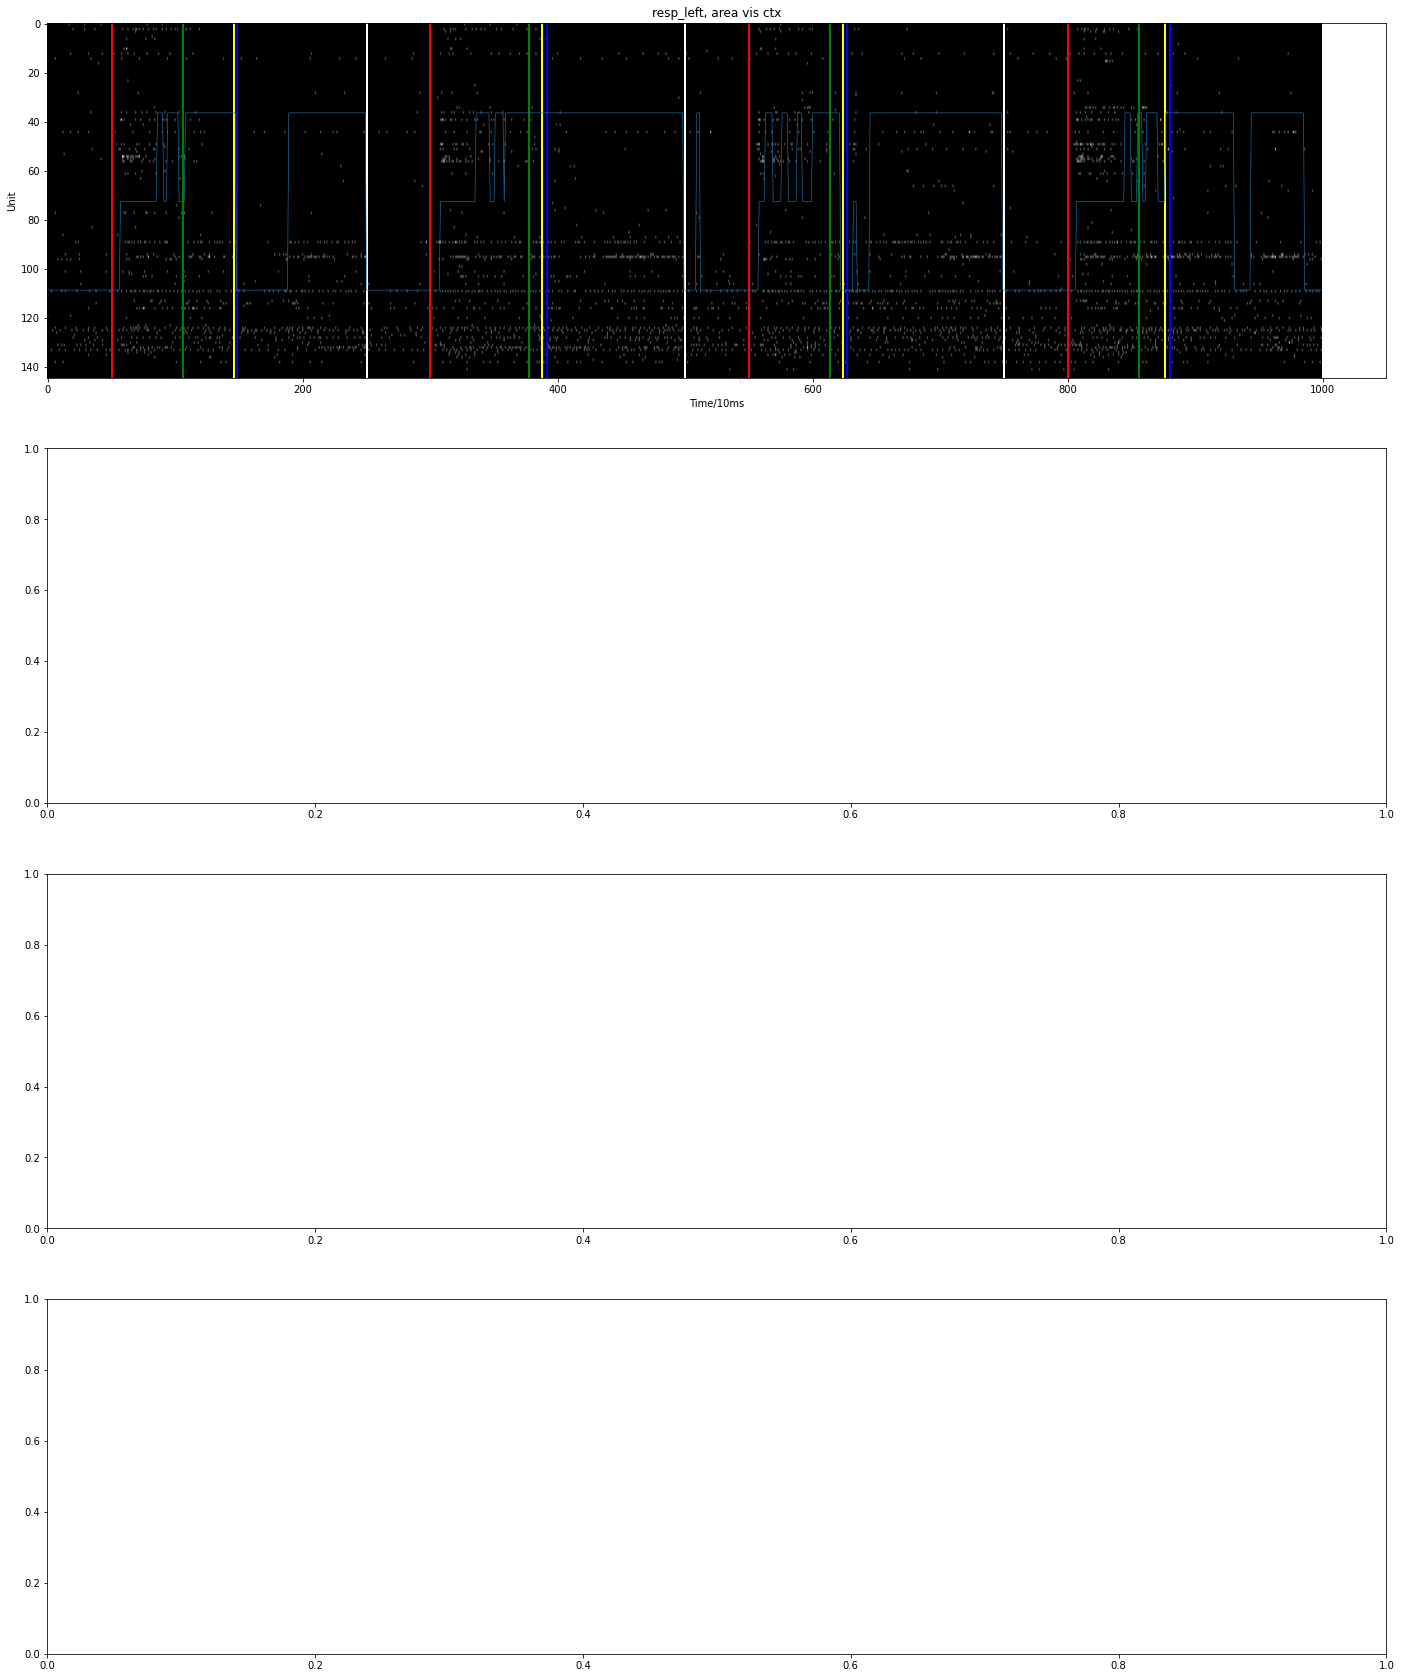

In [9]:
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['resp_left', 'no_resp', 'resp_right']
f, axes = plt.subplots(nrows=nareas, figsize=(24, 30))

for i in range(1):

    # resp_right
    neural_activity_resp_left = neural_activity[barea==i][:, resp_right_id, :]
    num_neurons = neural_activity_resp_left.shape[0]
    resp_left_input = neural_activity_resp_left.reshape(num_neurons, neural_activity_resp_left.shape[1]*time_bins)

    p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
    p_hmm.fit(resp_left_input.T, method="em", num_iters = 300)
    states_seq = p_hmm.most_likely_states(resp_left_input.T)
    
    resp_left_trial = resp_left_input[:, :n_trial*time_bins]
    states_seq_trial = states_seq[:n_trial*time_bins]

    axes[i].imshow(resp_left_trial, aspect='auto', cmap='gray')
    for j in range(n_trial):
        axes[i].axvline(x=stim_onset/bin_size+time_bins*j, color='red', linewidth=2, label='stim_onset')
        axes[i].axvline(x=gocue[resp_left_id][j]/bin_size+time_bins*j, color='green', linewidth=2, label='go_cue')
        axes[i].axvline(x=feedback_time[resp_left_id][j]/bin_size+time_bins*j, color='blue', linewidth=2, label='feedback_time')
        axes[i].axvline(x=response_time[resp_left_id][j]/bin_size+time_bins*j, color='yellow', linewidth=2, label='response_time')
        axes[i].axvline(x=time_bins*(j+1), color='white', linewidth=2, label='trial_time')

    axes[i].set_ylabel("Unit")
    axes[i].set_xlabel("Time/10ms")
    axes[i].plot((states_seq_trial+1)/(num_states+1)*resp_left_trial.shape[0], linewidth=0.6)
    axes[i].set_title(f'{trial_types[1]}, area {regions[i]}')

plt.tight_layout
plt.show()

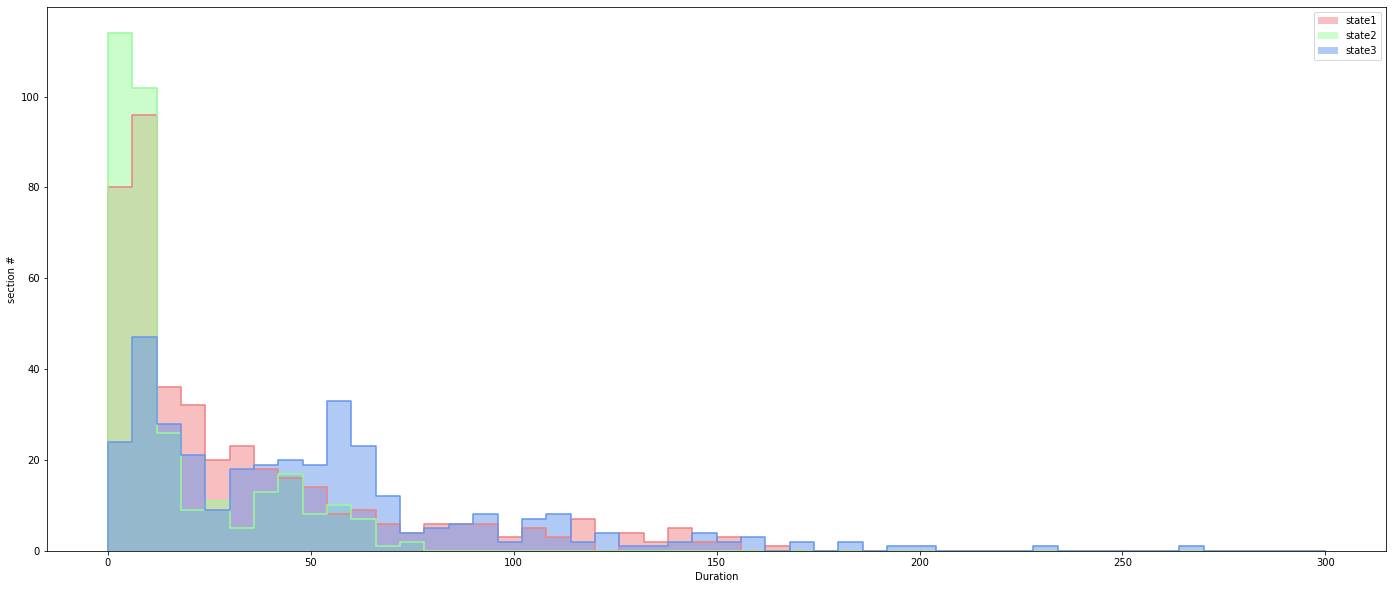

In [10]:
plot_hist_transition(states_seq)

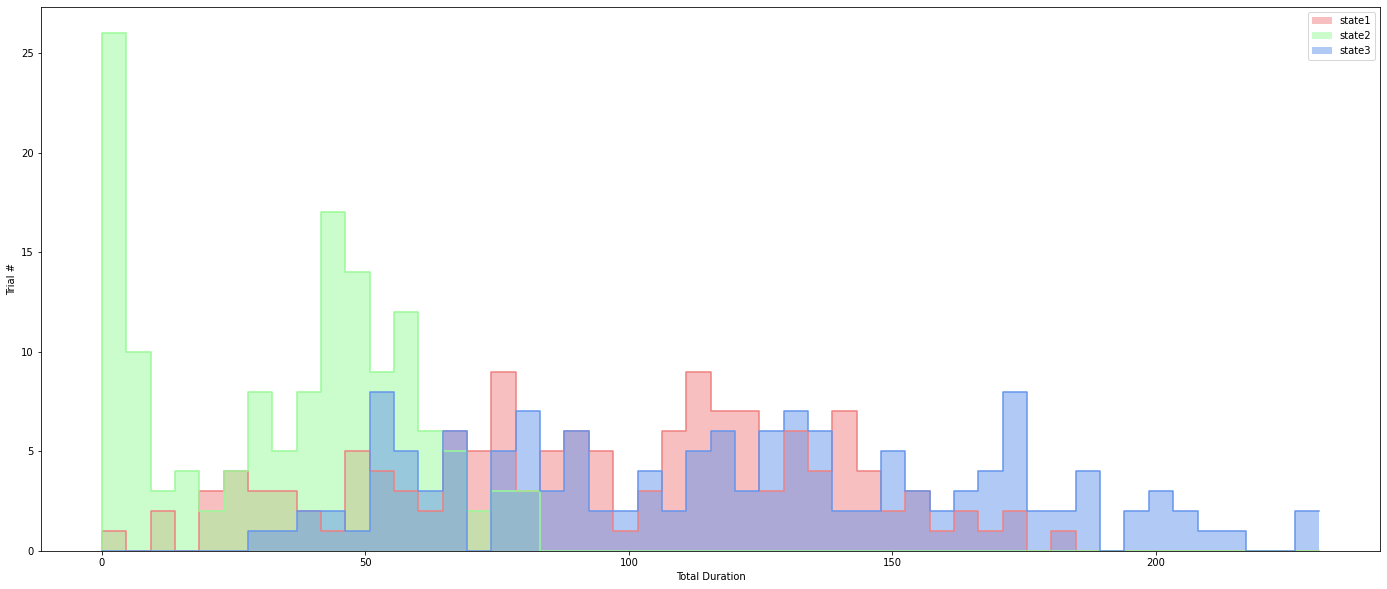

In [13]:
plot_hist_duration(states_seq, neural_activity_resp_left.shape[1], time_bins,num_states)

In [27]:
states_seq.reshape(neural_activity_resp_left.shape[1],time_bins).shape

(141, 250)

LP: -91932.7: 100%|███████████████████████████| 300/300 [01:00<00:00,  4.95it/s]


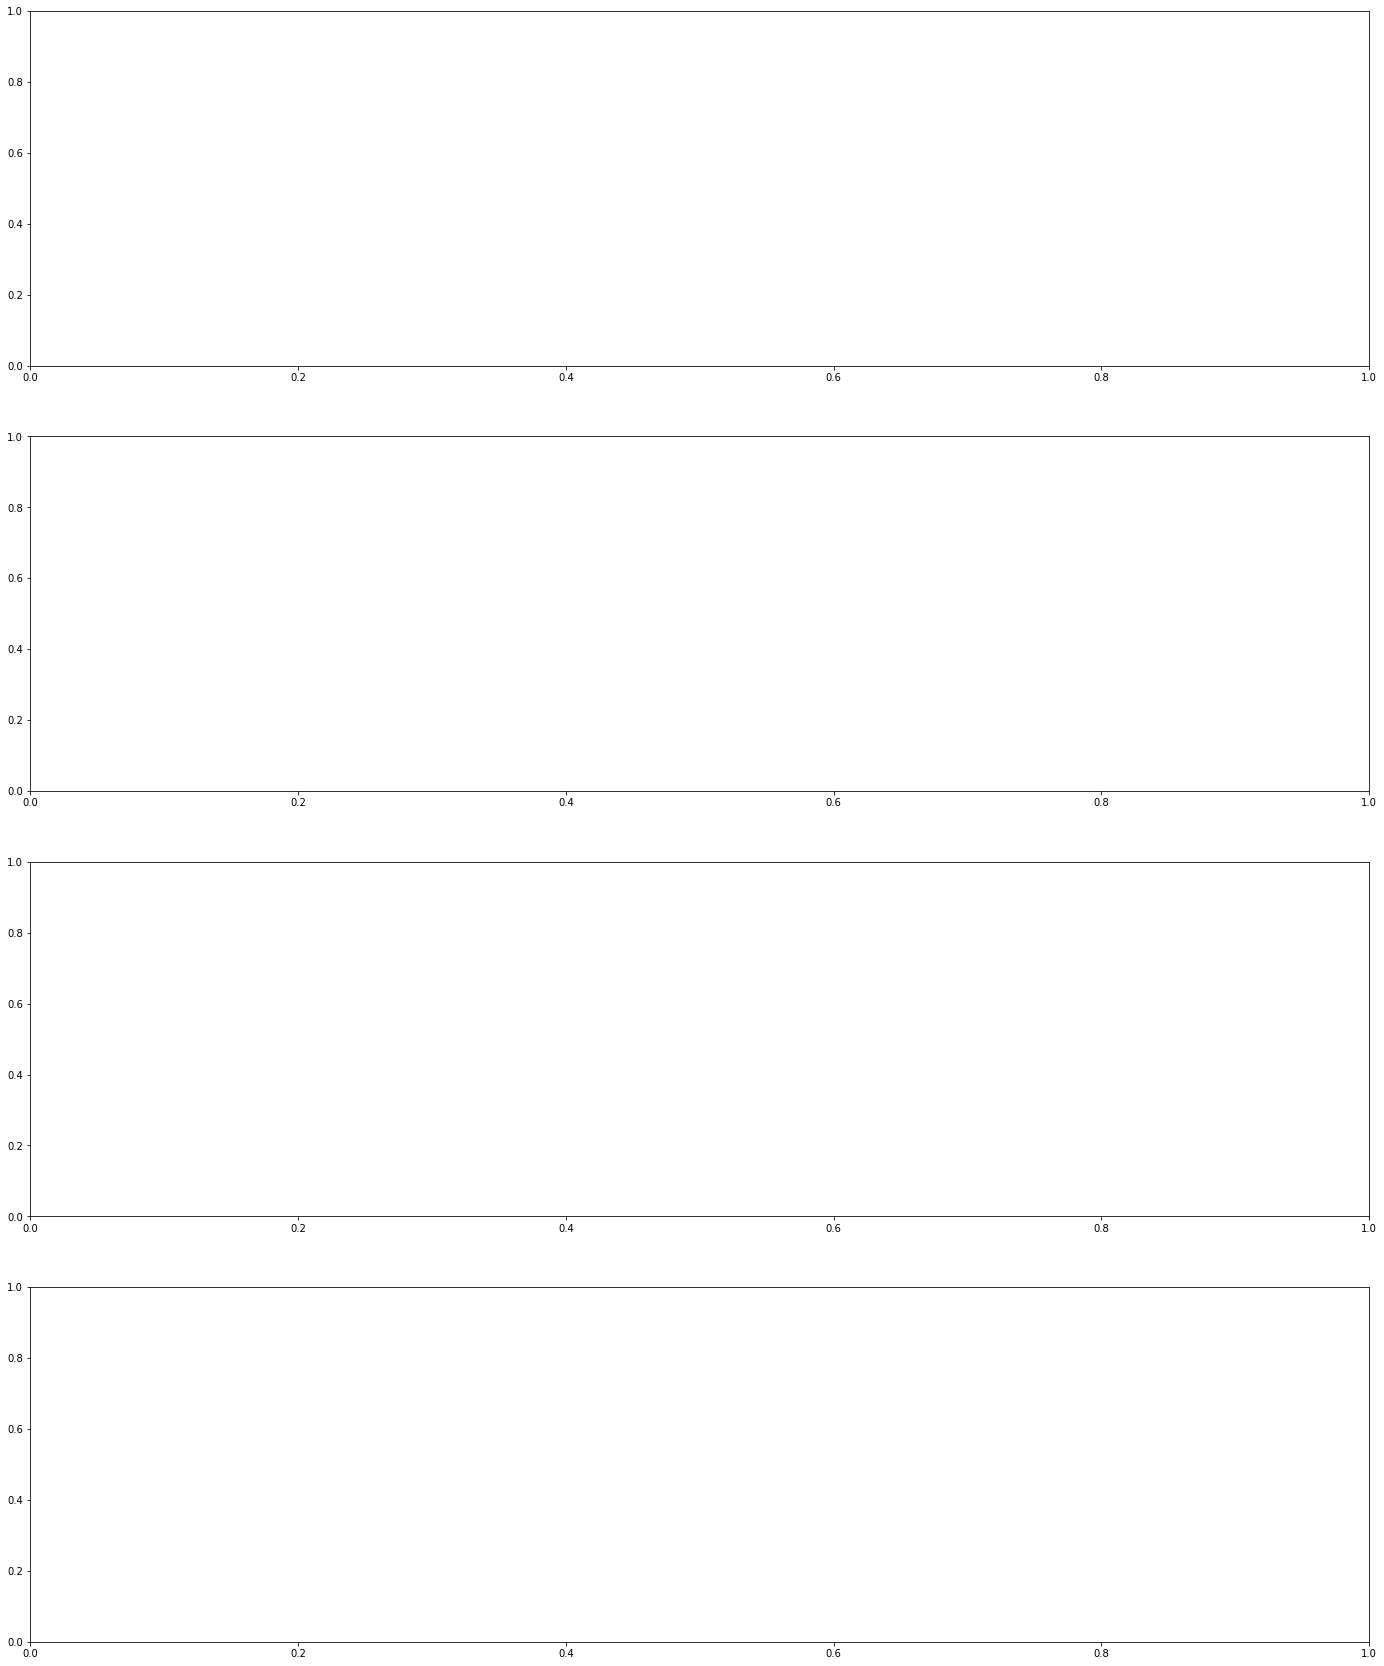

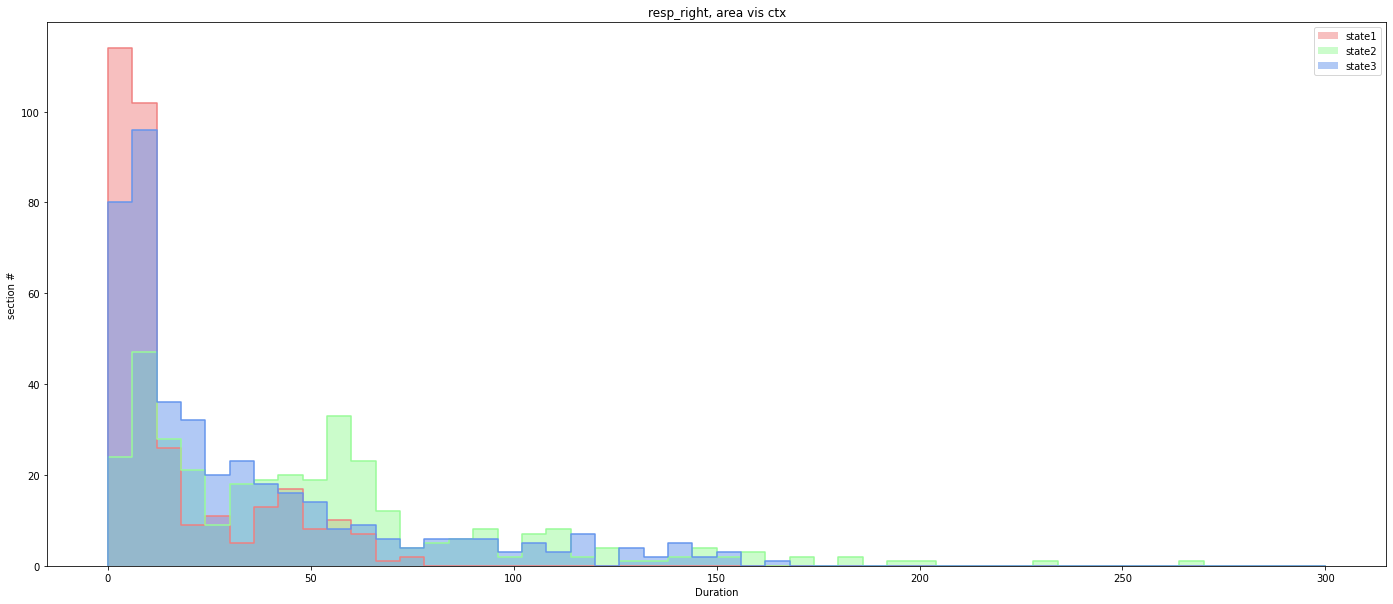

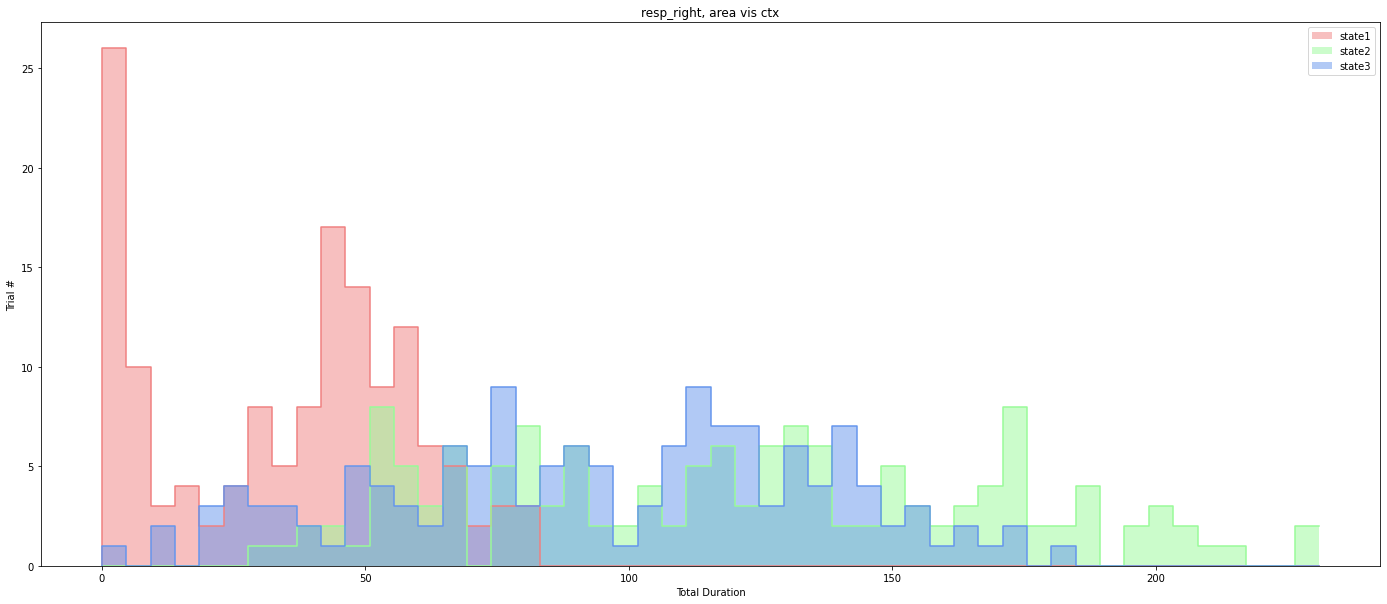

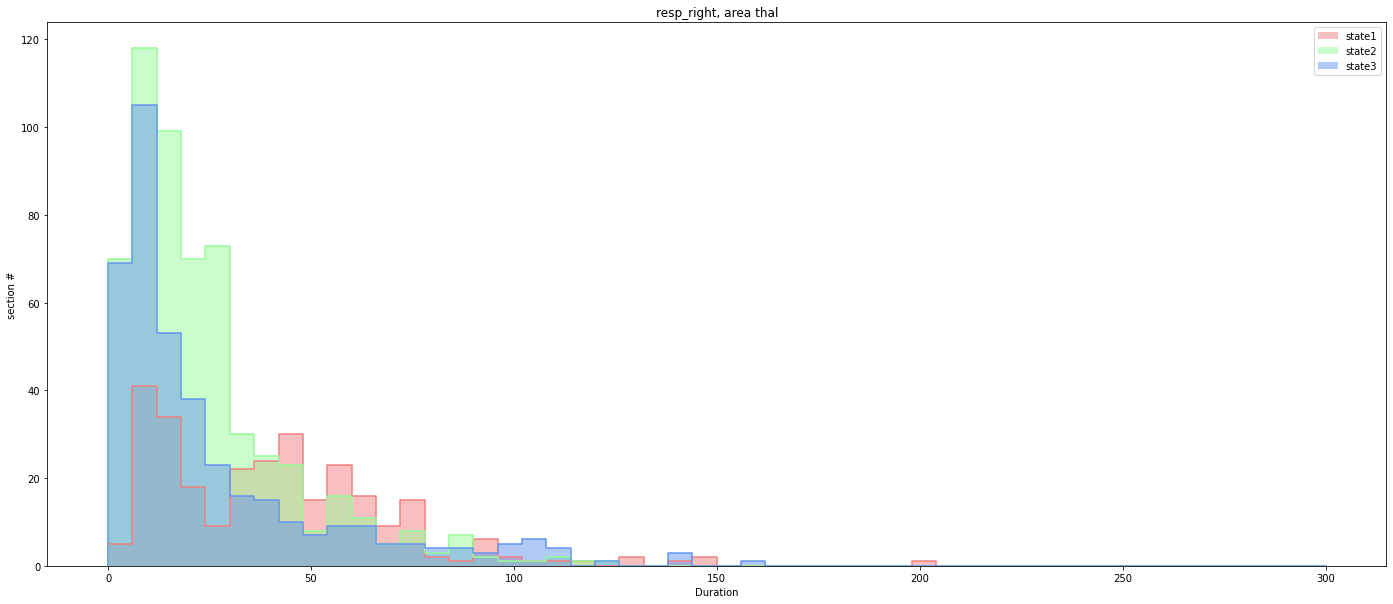

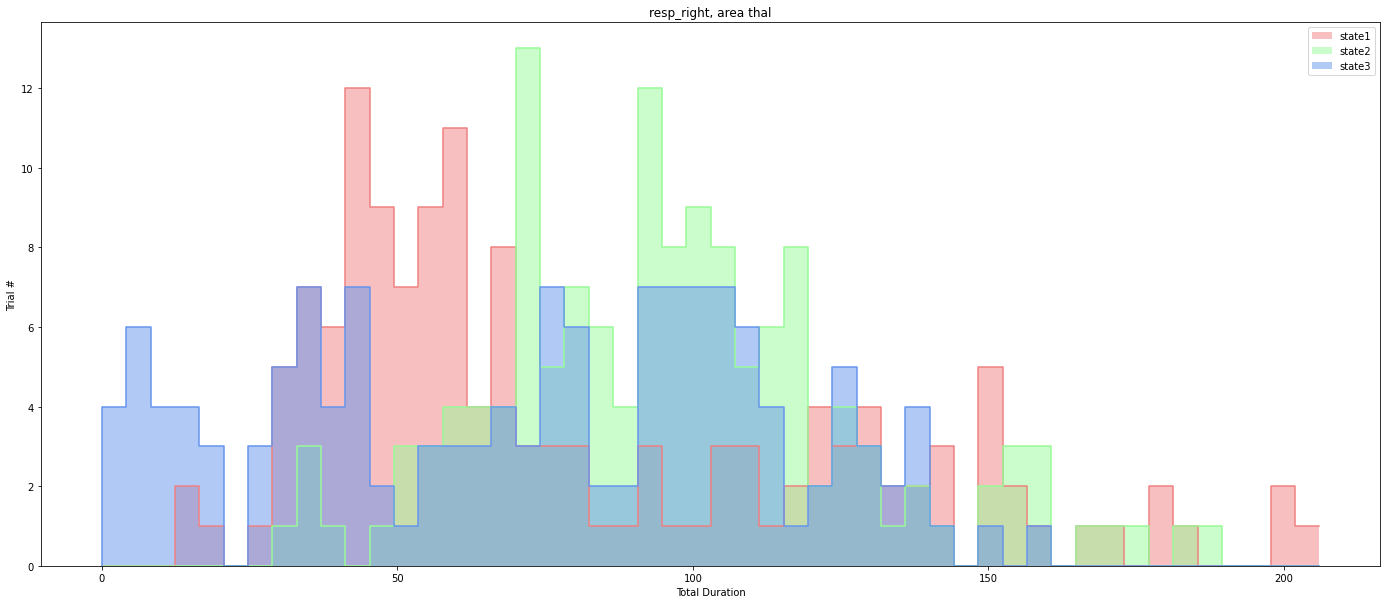

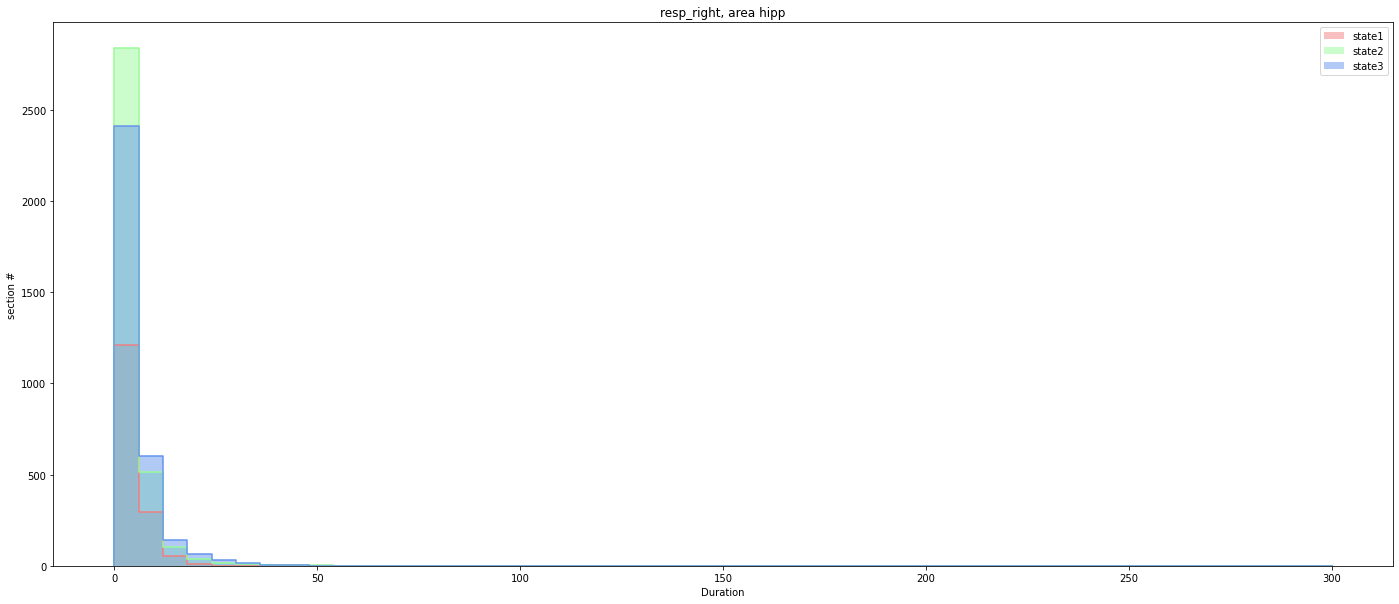

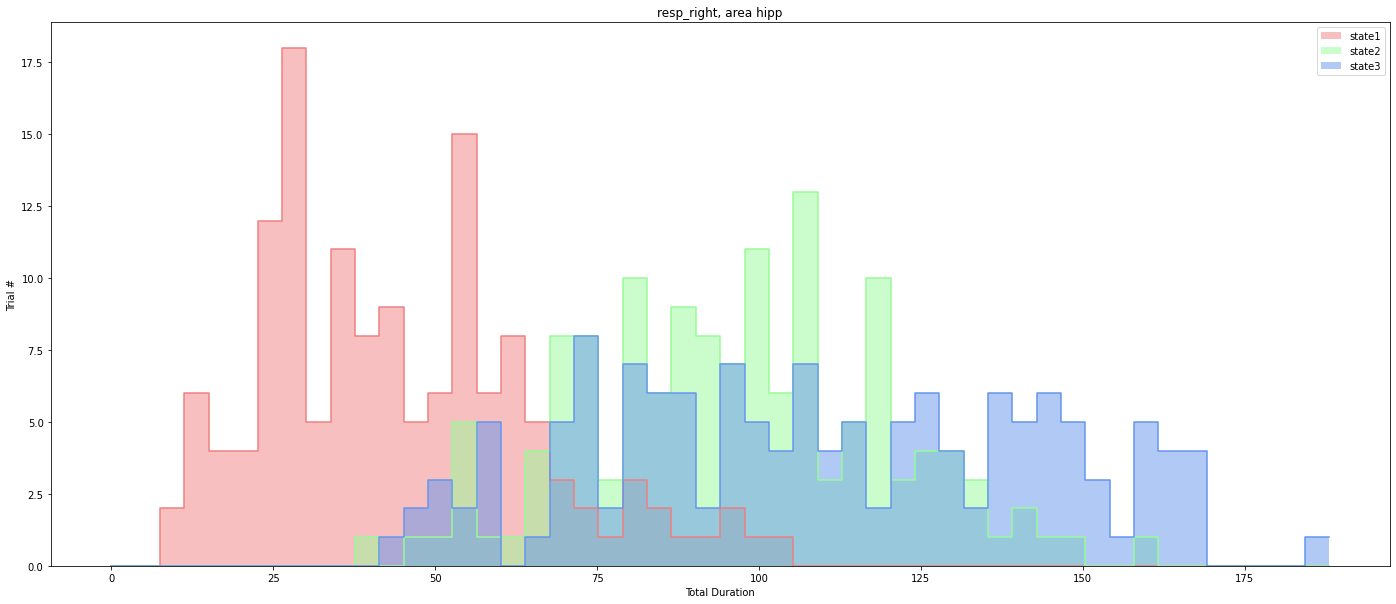

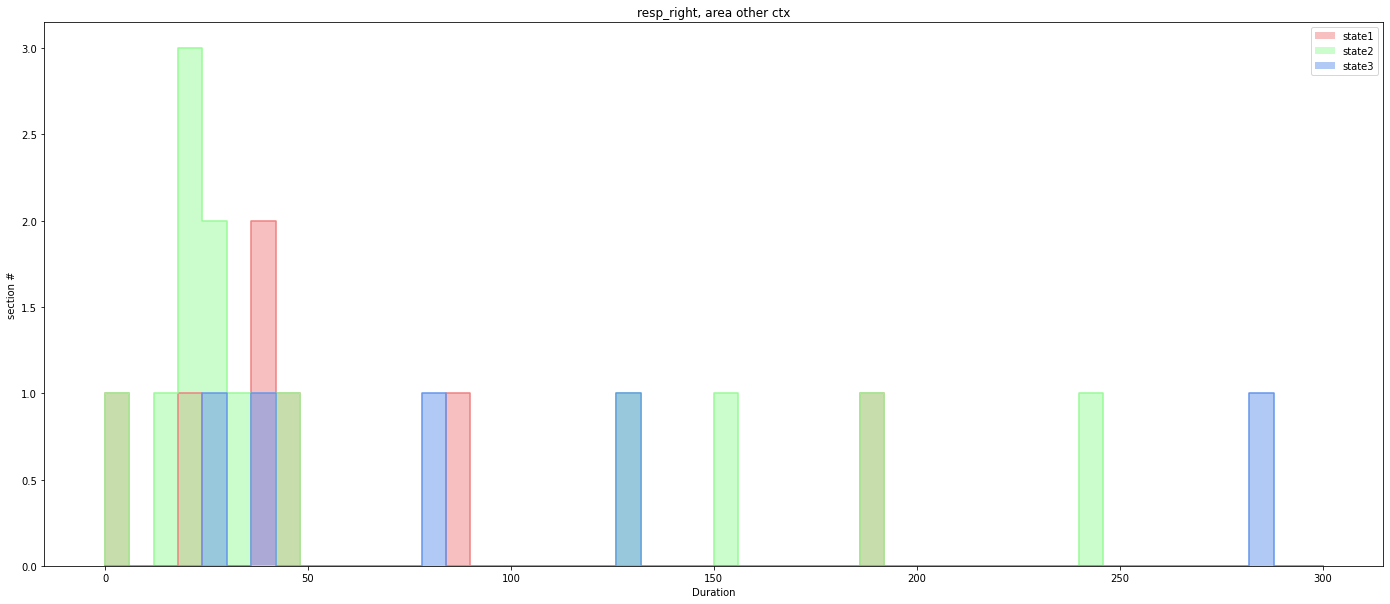

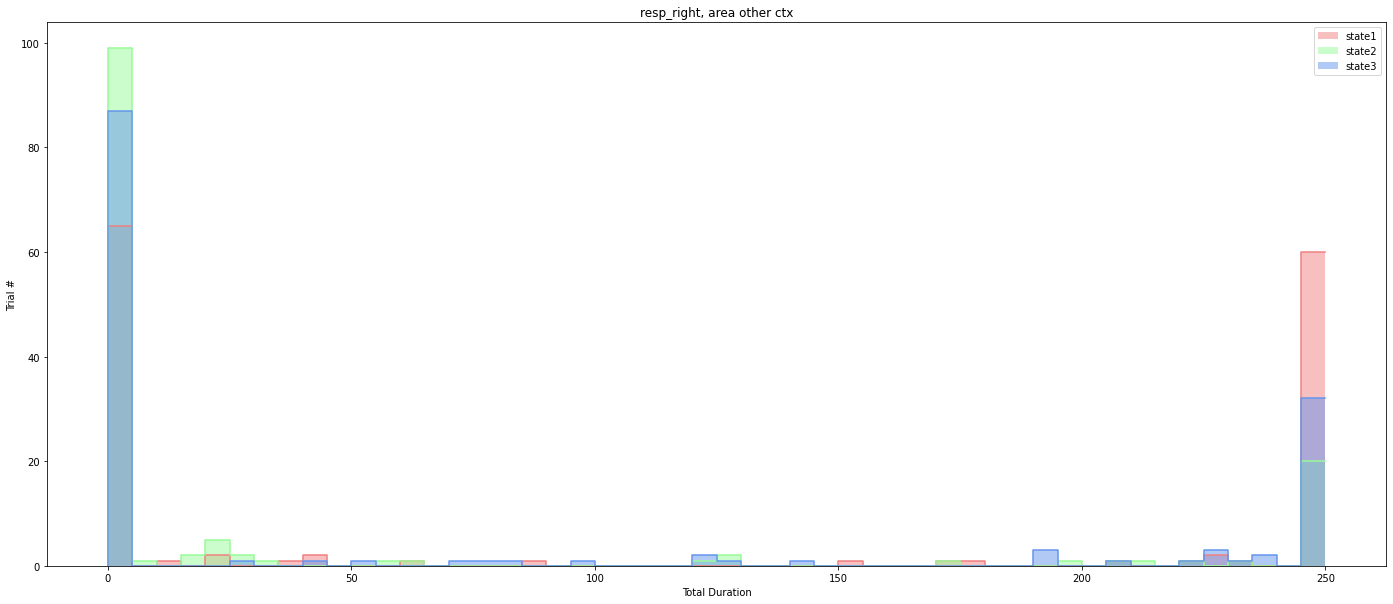

In [15]:
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['resp_left', 'no_resp', 'resp_right']

for i in range(nareas):

    # resp_right
    neural_activity_resp_left = neural_activity[barea==i][:, resp_right_id, :]
    num_neurons = neural_activity_resp_left.shape[0]
    resp_left_input = neural_activity_resp_left.reshape(num_neurons, neural_activity_resp_left.shape[1]*time_bins)

    p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
    p_hmm.fit(resp_left_input.T, method="em", num_iters = 300)
    states_seq = p_hmm.most_likely_states(resp_left_input.T)
    
    plot_hist_transition(states_seq,trial_types[2],regions[i])
    plot_hist_duration(states_seq, neural_activity_resp_left.shape[1],
                       time_bins,
                       num_states,
                       trial_types[2],
                       regions[i])